---
This notebook will use tensorflow to determine the color of a card: red, green or purple.

We'll first get pixel data, saving `.npy` files in `rgb-data`.  Some of the input images have an alpha channel, some don't.
  
---

In [2]:
import os
import numpy as np
from PIL import Image


input_directory = 'resized-images'
output_directory = 'rgb-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  number_of_channels = np.array(image).shape[2]
  pixel_data = [pixel for row in np.array(image) for pixel in row]
  if number_of_channels == 4:
    rgb_data = np.array([(r, g, b) for r, g, b, _ in pixel_data]).flatten()
  elif number_of_channels == 3:
    rgb_data = np.array(pixel_data).flatten()

  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, rgb_data)

---
Split data into training, validation and test folds.

---

In [3]:
import hashlib


input_directory = 'rgb-data'

# Load all the data into an array.
# Each element is a tuple: (filename, numpy data).
# The filename structure is "<number>-<color>-<texture>-<shape>-<rotation>.png"
all_data = [
  (f, np.load(os.path.join(input_directory, f))) for f in os.listdir(input_directory)
]

# Hash the filename and sort the hashes alphabetically.
all_data_with_hashes = [
  (filename, hashlib.md5(filename).hexdigest(), data) for filename, data in all_data
]
all_data_sorted = sorted(all_data_with_hashes, key=lambda element: element[1])

# Save 20% of the data for testing (the final, one-shot evaluation of performance).
split_index = int(0.2 * len(all_data_sorted))
test_data = all_data_sorted[0:split_index]
remaining_data = all_data_sorted[split_index:]

# Now save 20% of the remaining data for validation -- the rest is for training.
split_index = int(0.2 * len(remaining_data))
validation_data = remaining_data[0:split_index]
training_data = remaining_data[split_index:]

# For convenience, get all the pixel data into separate arrays.
training_pixel_data = [pixel_data for _, _, pixel_data in training_data]
validation_pixel_data = np.array([pixel_data for _, _, pixel_data in validation_data])
test_pixel_data = np.array([pixel_data for _, _, pixel_data in test_data])

# Each filename, in its text, has an embedded color.
# We need to convert those classes (the output ground truth) into label arrays.
all_labels = {
  'red': [1., 0., 0.],
  'green': [0., 1., 0.],
  'purple': [0., 0., 1.],
}
training_labels = [
  all_labels[filename.split('-')[1]] for filename, _, _ in training_data
]
validation_labels = [
  all_labels[filename.split('-')[1]] for filename, _, _ in validation_data
]
test_labels = [
  all_labels[filename.split('-')[1]] for filename, _, _ in test_data
]

---
setup tensorflow

---

In [4]:
import random
import tensorflow as tf


learning_rate = 0.0000005
regularization_factor = 1e-4
card_width, card_height, card_channels = 150, 150, 3
first_hidden_layer_size, second_hidden_layer_size = 1024, 256

graph = tf.Graph()
with graph.as_default():
  # Setup the training steps.
  tf_training_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height*card_channels])
  tf_training_labels = tf.placeholder(tf.float32, shape=[None, 3])
  
  # Create hidden layers of ReLUs.
  first_hidden_weights = tf.Variable(
    tf.truncated_normal([card_width*card_height*card_channels, first_hidden_layer_size]), name='first_hidden_weights')
  first_hidden_biases = tf.Variable(
    tf.zeros([first_hidden_layer_size]), name='first_hidden_biases')
  first_hidden_layer = tf.nn.relu(tf.matmul(tf_training_data, first_hidden_weights) + first_hidden_biases)
  second_hidden_weights = tf.Variable(
    tf.truncated_normal([first_hidden_layer_size, second_hidden_layer_size]), name='second_hidden_weights')
  second_hidden_biases = tf.Variable(
    tf.zeros([second_hidden_layer_size]), name='second_hidden_biases')
  second_hidden_layer = tf.nn.relu(tf.matmul(first_hidden_layer, second_hidden_weights) + second_hidden_biases)
  
  # Build the output layer.
  output_weights = tf.Variable(tf.truncated_normal([second_hidden_layer_size, 3]), name='output_weights')
  output_biases = tf.Variable(tf.zeros([3]), name='output_biases')
  output_logits = tf.matmul(second_hidden_layer, output_weights) + output_biases
  training_estimate = tf.nn.softmax(output_logits)

  # Calculate loss and setup the optimizer.
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_logits, tf_training_labels))
  l2_regularization = (tf.nn.l2_loss(output_weights) +
                       tf.nn.l2_loss(first_hidden_weights) +
                       tf.nn.l2_loss(second_hidden_weights))
  loss += regularization_factor * l2_regularization
  training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Setup validation.  We have to reshape into a "dense tensor"
  # by, essentially, combining this array of arrays into a true matrix.
  tf_validation_pixel_data = tf.constant(
    validation_pixel_data.reshape((-1, card_width*card_height*card_channels)).astype(np.float32))
  validation_first_hidden_layer = tf.nn.relu(
    tf.matmul(tf_validation_pixel_data, first_hidden_weights) + first_hidden_biases)
  validation_second_hidden_layer = tf.nn.relu(
    tf.matmul(validation_first_hidden_layer, second_hidden_weights) + second_hidden_biases)
  validation_logits = tf.matmul(validation_second_hidden_layer, output_weights) + output_biases
  validation_estimate = tf.nn.softmax(validation_logits)

  # Setup the final test run.
  tf_test_pixel_data = tf.constant(
    test_pixel_data.reshape((-1, card_width*card_height*card_channels)).astype(np.float32))
  test_first_hidden_layer = tf.nn.relu(
    tf.matmul(tf_test_pixel_data, first_hidden_weights) + first_hidden_biases)
  test_second_hidden_layer = tf.nn.relu(
    tf.matmul(test_first_hidden_layer, second_hidden_weights) + second_hidden_biases)
  test_logits = tf.matmul(test_second_hidden_layer, output_weights) + output_biases
  test_estimate = tf.nn.softmax(test_logits)

---
aside: create a small function to calculate the accuracy of a set of predictions
  
---

In [5]:
def calculate_accuracy(predictions, ground_truth):
  """Determine what proportion of predictions are accurate based on ground truth."""
  correctness = np.sum(np.argmax(predictions, 1) == np.argmax(ground_truth, 1))
  return 100. * correctness / predictions.shape[0]

---
and run the optimizer in batches

---

In [8]:
accuracies = []
total_iterations = 300
batch_size = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  variable_saver = tf.train.Saver()

  for iteration in range(total_iterations):
    batch_data = random.sample(training_data, batch_size)
    batch_input_pixel_data = [pixel_data for _, _, pixel_data in batch_data]
    batch_labels = [
      all_labels[filename.split('-')[1]] for filename, _, _ in batch_data
    ]
    batch_training_data = {
      tf_training_data: batch_input_pixel_data,
      tf_training_labels: batch_labels,
    }
    _, step_loss, training_predictions = session.run(
      [training_step, loss, training_estimate], feed_dict=batch_training_data)
  
    if (iteration % (total_iterations / 20)) == 0:
      training_accuracy = calculate_accuracy(training_predictions, batch_labels)
      validation_accuracy = calculate_accuracy(validation_estimate.eval(), validation_labels)
      accuracies.append((iteration, training_accuracy, validation_accuracy))
      if (iteration % (total_iterations / 10)) == 0:
        print 'iteration: %s -> loss: %s, training accuracy: %0.1f%%, validation accuracy: %0.1f%%' % (
          iteration, step_loss, training_accuracy, validation_accuracy)
  variable_saver.save(session, '/tmp/detect-color-model.ckpt', latest_filename='detect-color-checkpoint-list')
  print '\ntest accuracy: %0.1f%%' % calculate_accuracy(test_estimate.eval(), test_labels)

iteration: 0 -> loss: 4.40239e+06, training accuracy: 36.0%, validation accuracy: 36.9%
iteration: 30 -> loss: 618982.0, training accuracy: 52.0%, validation accuracy: 40.8%
iteration: 60 -> loss: 178449.0, training accuracy: 70.0%, validation accuracy: 63.1%
iteration: 90 -> loss: 103500.0, training accuracy: 73.0%, validation accuracy: 62.1%
iteration: 120 -> loss: 33806.2, training accuracy: 82.0%, validation accuracy: 65.0%
iteration: 150 -> loss: 55158.7, training accuracy: 87.0%, validation accuracy: 81.6%
iteration: 180 -> loss: 36959.7, training accuracy: 77.0%, validation accuracy: 68.0%
iteration: 210 -> loss: 3810.19, training accuracy: 99.0%, validation accuracy: 84.5%
iteration: 240 -> loss: 2673.43, training accuracy: 100.0%, validation accuracy: 79.6%
iteration: 270 -> loss: 2673.43, training accuracy: 100.0%, validation accuracy: 78.6%

test accuracy: 86.0%


---
plot the accuracy vs iteration number

---

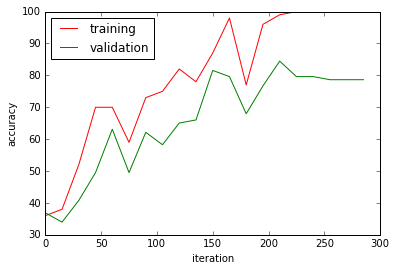

In [9]:
% matplotlib inline
import matplotlib.pyplot as plt


iterations, training_accuracies, validation_accuracies = zip(*accuracies)
plt.plot(iterations, training_accuracies, 'r-', label='training')
plt.plot(iterations, validation_accuracies, 'g-', label='validation')
_ = plt.xlabel('iteration')
_ = plt.ylabel('accuracy')
_ = plt.legend(loc='best')